In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
class MoveNetPreprocessor(object):
    
  def __init__(self,
               images_in_folder,
               images_out_folder,

    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
  
   
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)

        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
 
    print('\n'.join(self._messages))

    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

SyntaxError: '(' was never closed (2743316724.py, line 3)

In [5]:


test_image_url = "https://www.artofliving.org/sites/www.artofliving.org/files/styles/original_image/public/wysiwyg_imageupload/Utkatasana%20%28Chair%20pose%29.jpg" #@param {type:"string"}
!wget -O /tmp/image.jpeg {test_image_url}

if len(test_image_url):
  image = tf.io.read_file('chair_pose_testing.jpeg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  _ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                               close_figure=False, keep_input_size=True)

zsh:1: command not found: wget


2024-02-27 10:48:48.057763: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: chair_pose_testing.jpeg; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} chair_pose_testing.jpeg; No such file or directory [Op:ReadFile]

In [ ]:
is_skip_step_1 = False #@param ["False", "True"] {type:"raw"}

### (Optional) Upload your own pose dataset

In [9]:
use_custom_dataset = False #@param ["False", "True"] {type:"raw"}

dataset_is_split = False #@param ["False", "True"] {type:"raw"}

If you want to train the pose classifier with your own labeled poses (they can be any poses, not just yoga poses), follow these steps:

1. Set the above `use_custom_dataset` option to **True**.

2. Prepare an archive file (ZIP, TAR, or other) that includes a folder with your images dataset. The folder must include sorted images of your poses as follows.

  If you've already split your dataset into train and test sets, then set `dataset_is_split` to **True**. That is, your images folder must include "train" and "test" directories like this:

    ```
    yoga_poses/
    |__ train/
        |__ downdog/
            |______ 00000128.jpg
            |______ ...
    |__ test/
        |__ downdog/
            |______ 00000181.jpg
            |______ ...
    ```

    Or, if your dataset is NOT split yet, then set
    `dataset_is_split` to **False** and we'll split it up based
    on a specified split fraction. That is, your uploaded images
    folder should look like this:

    ```
    yoga_poses/
    |__ downdog/
        |______ 00000128.jpg
        |______ 00000181.jpg
        |______ ...
    |__ goddess/
        |______ 00000243.jpg
        |______ 00000306.jpg
        |______ ...
    ```
3. Click the **Files** tab on the left (folder icon) and then click **Upload to session storage** (file icon).
4. Select your archive file and wait until it finishes uploading before you proceed.
5. Edit the following code block to specify the name of your archive file and images directory. (By default, we expect a ZIP file, so you'll need to also modify that part if your archive is another format.)
6. Now run the rest of the notebook.

In [10]:
#@markdown Be sure you run this cell. It's hiding the `split_into_train_test()` function that's called in the next code block.

import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes. For example:
      yoga_poses/
      |__ downdog/
          |______ 00000128.jpg
          |______ 00000181.jpg
          |______ ...
      |__ goddess/
          |______ 00000243.jpg
          |______ 00000306.jpg
          |______ ...
      ...
    images_dest: Path to a directory where you want the split dataset to be
      saved. The results looks like this:
      split_yoga_poses/
      |__ train/
          |__ downdog/
              |______ 00000128.jpg
              |______ ...
      |__ test/
          |__ downdog/
              |______ 00000181.jpg
              |______ ...
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [11]:
if use_custom_dataset:
  # ATTENTION:
  # You must edit these two lines to match your archive and images folder name:
  # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
  !unzip -q YOUR_DATASET_ARCHIVE_NAME.zip
  dataset_in = 'YOUR_DATASET_DIR_NAME'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

In [12]:
if not is_skip_step_1 and not use_custom_dataset:
  IMAGES_ROOT = "yoga_poses"

NameError: name 'is_skip_step_1' is not defined

In [13]:
if not is_skip_step_1:
  images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)

NameError: name 'is_skip_step_1' is not defined

### Preprocess the `TEST` dataset

In [14]:
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

NameError: name 'is_skip_step_1' is not defined

## Part 2: Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.

You'll build a TensorFlow model that takes the landmark coordinates and predicts the pose class that the person in the input image performs. The model consists of two submodels:

* Submodel 1 calculates a pose embedding (a.k.a feature vector) from the detected landmark coordinates.
* Submodel 2 feeds pose embedding through several `Dense` layer to predict the pose class.

You'll then train the model based on the dataset that were preprocessed in part 1.

### (Optional) Download the preprocessed dataset if you didn't run part 1

In [15]:
# Download the preprocessed CSV files which are the same as the output of step 1
if is_skip_step_1:
  !wget -O train_data.csv http://download.tensorflow.org/data/pose_classification/yoga_train_data.csv
  !wget -O test_data.csv http://download.tensorflow.org/data/pose_classification/yoga_test_data.csv

  csvs_out_train_path = 'train_data.csv'
  csvs_out_test_path = 'test_data.csv'
  is_skipped_step_1 = True

NameError: name 'is_skip_step_1' is not defined

### Load the preprocessed CSVs into `TRAIN` and `TEST` datasets.

In [39]:
def load_pose_landmarks(csv_path):

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

Load and split the original `TRAIN` dataset into `TRAIN` (85% of the data) and `VALIDATE` (the remaining 15%).

In [40]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [41]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [42]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [43]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

                                                                                                  
 tf.math.multiply_2 (TFOpLa  (None, 2)                    0         ['tf.compat.v1.gather_2[0][0]'
 mbda)                                                              ]                             
                                                                                                  
 tf.math.multiply_3 (TFOpLa  (None, 2)                    0         ['tf.compat.v1.gather_3[0][0]'
 mbda)                                                              ]                             
                                                                                                  
 tf.broadcast_to_1 (TFOpLam  (None, 17, 2)                0         ['tf.expand_dims_1[0][0]',    
 bda)                                                                'tf.compat.v1.floor_div_1[0][
                                                                    0]']                          
          

In [44]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
 1/37 [..............................] - ETA: 19s - loss: 1.5816 - accuracy: 0.3125
Epoch 1: val_accuracy improved from -inf to 0.56863, saving model to weights.best.hdf5
37/37 [==============================] - 1s 6ms/step - loss: 1.5188 - accuracy: 0.4325 - val_loss: 1.3644 - val_accuracy: 0.5686
Epoch 2/200
 1/37 [..............................] - ETA: 0s - loss: 1.3952 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.56863
37/37 [==============================] - 0s 1ms/step - loss: 1.2617 - accuracy: 0.5173 - val_loss: 1.0488 - val_accuracy: 0.5588
Epoch 3/200
 1/37 [..............................] - ETA: 0s - loss: 1.0240 - accuracy: 0.6250
Epoch 3: val_accuracy improved from 0.56863 to 0.72549, saving model to weights.best.hdf5
37/37 [==============================] - 0s 1ms/step - loss: 1.0361 - accuracy: 0.5502 - val_loss: 0.8587 - val_accuracy: 0.7255
Epoch 4/200
 1/37 [..............................] - ETA: 0s - loss: 0.7866 - accuracy: 0.6250
Epoc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 0s 2ms/step - loss: 0.9022 - accuracy: 0.6246 - val_loss: 0.7294 - val_accuracy: 0.8137
Epoch 5/200
 1/37 [..............................] - ETA: 0s - loss: 0.9959 - accuracy: 0.5625
Epoch 5: val_accuracy improved from 0.81373 to 0.83333, saving model to weights.best.hdf5
37/37 [==============================] - 0s 1ms/step - loss: 0.8292 - accuracy: 0.6834 - val_loss: 0.6135 - val_accuracy: 0.8333
Epoch 6/200
 1/37 [..............................] - ETA: 0s - loss: 0.8091 - accuracy: 0.6875
Epoch 6: val_accuracy improved from 0.83333 to 0.86275, saving model to weights.best.hdf5
37/37 [==============================] - 0s 1ms/step - loss: 0.7023 - accuracy: 0.7439 - val_loss: 0.5274 - val_accuracy: 0.8627
Epoch 7/200
 1/37 [..............................] - ETA: 0s - loss: 0.6682 - accuracy: 0.7500
Epoch 7: val_accuracy improved from 0.86275 to 0.91176, saving model to weights.best.hdf5
37/37 [==============================] - 0s 2ms/step - los

Epoch 33/200
 1/37 [..............................] - ETA: 0s - loss: 0.1548 - accuracy: 0.9375
Epoch 33: val_accuracy did not improve from 0.98039
37/37 [==============================] - 0s 1ms/step - loss: 0.1520 - accuracy: 0.9516 - val_loss: 0.0750 - val_accuracy: 0.9706
Epoch 34/200
 1/37 [..............................] - ETA: 0s - loss: 0.2347 - accuracy: 0.9375
Epoch 34: val_accuracy did not improve from 0.98039
37/37 [==============================] - 0s 1ms/step - loss: 0.1592 - accuracy: 0.9533 - val_loss: 0.0728 - val_accuracy: 0.9706
Epoch 35/200
 1/37 [..............................] - ETA: 0s - loss: 0.2140 - accuracy: 0.9375
Epoch 35: val_accuracy did not improve from 0.98039
37/37 [==============================] - 0s 1ms/step - loss: 0.1220 - accuracy: 0.9637 - val_loss: 0.0762 - val_accuracy: 0.9706
Epoch 36/200
 1/37 [..............................] - ETA: 0s - loss: 0.0244 - accuracy: 1.0000
Epoch 36: val_accuracy did not improve from 0.98039
37/37 [==============

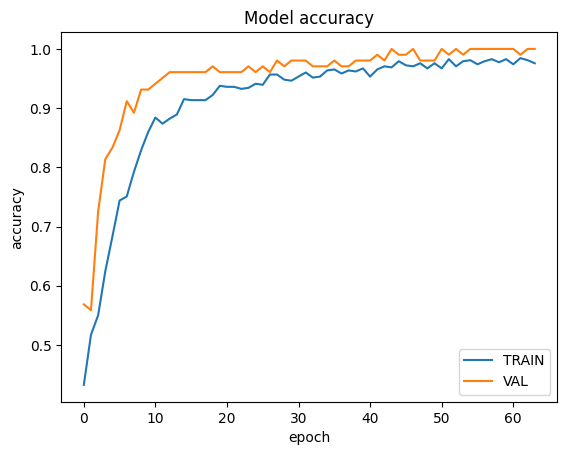

In [45]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [46]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 925us/step - loss: 0.0250 - accuracy: 0.9929


### Draw the confusion matrix to better understand the model performance

14/14 [==============================] - 0s 530us/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       0.99      1.00      0.99        84
       cobra       0.98      1.00      0.99        93
         dog       1.00      1.00      1.00        84
        tree       1.00      1.00      1.00        96
     warrior       1.00      0.96      0.98        68

    accuracy                           0.99       425
   macro avg       0.99      0.99      0.99       425
weighted avg       0.99      0.99      0.99       425



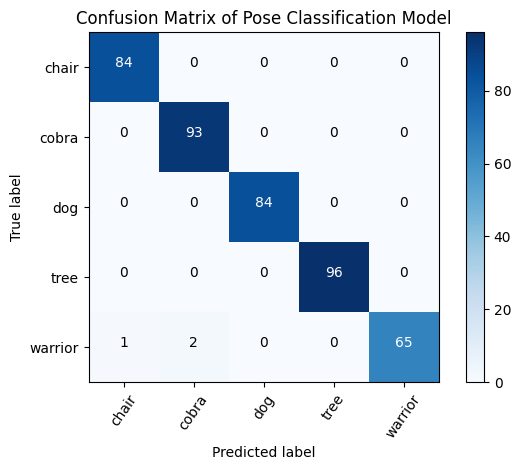

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### (Optional) Investigate incorrect predictions

You can look at the poses from the `TEST` dataset that were incorrectly predicted to see whether the model accuracy can be improved.

Note: This only works if you have run step 1 because you need the pose image files on your local machine to display them.

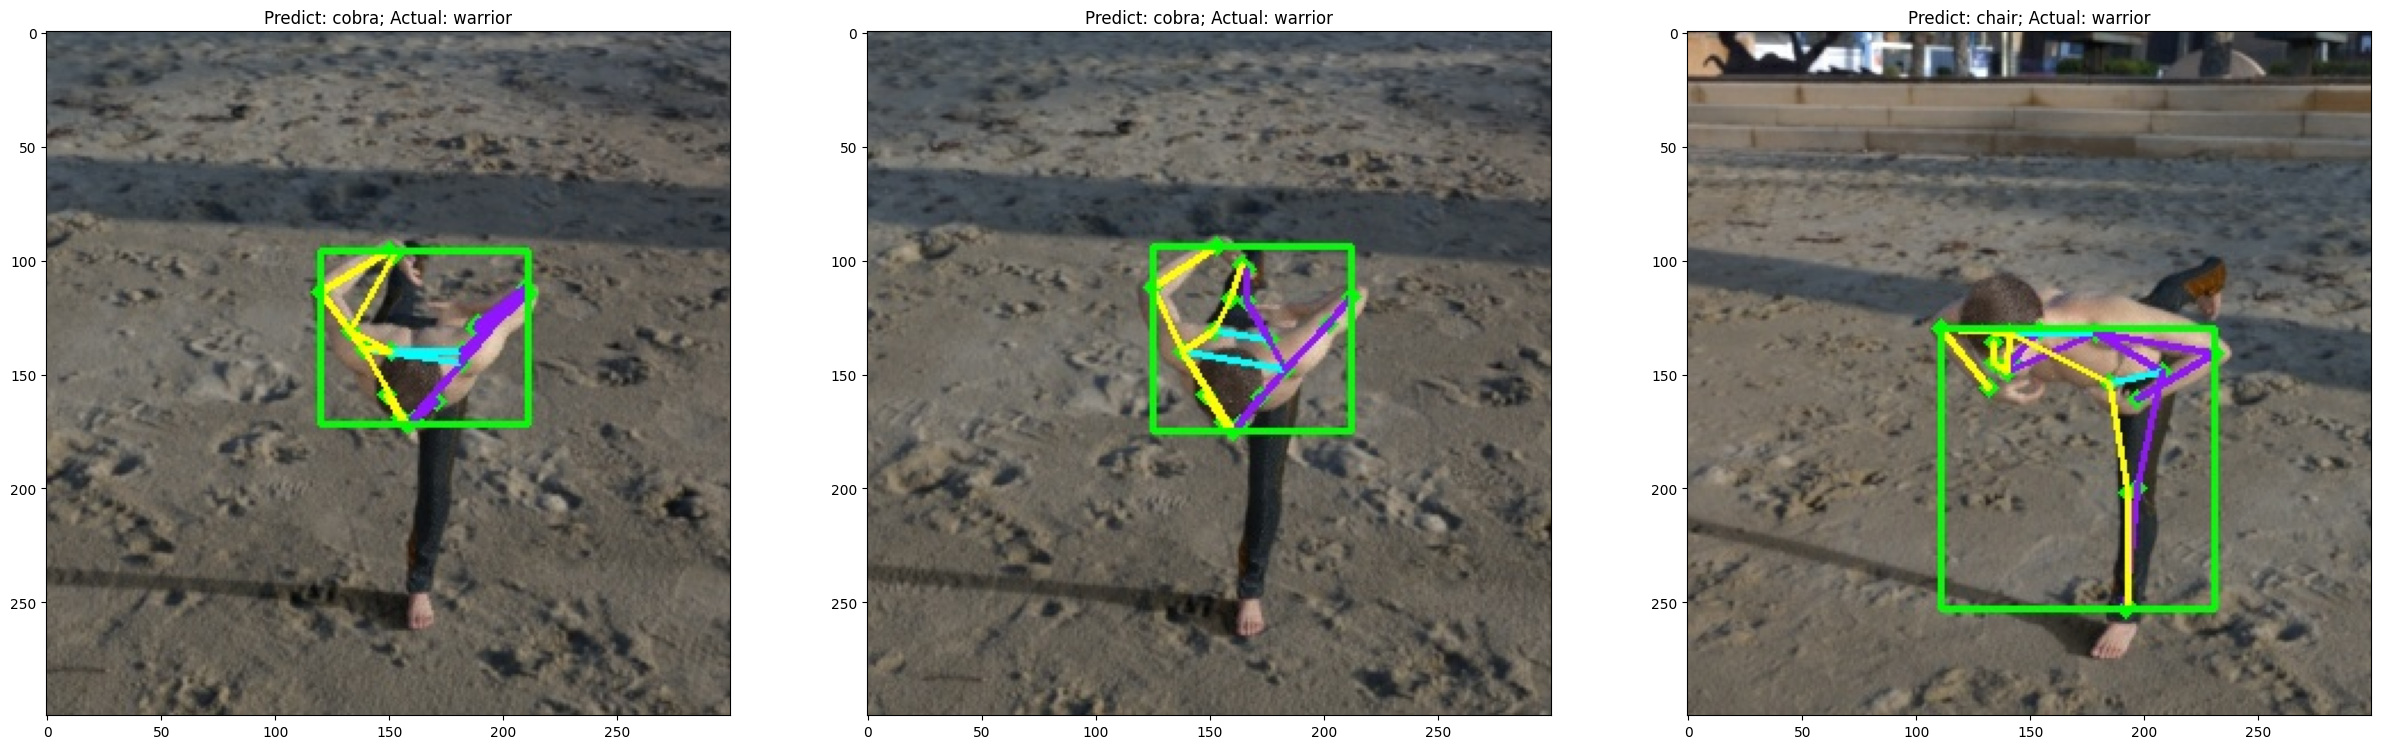

In [48]:
if is_skip_step_1:
  raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/c5/b69vxdr178q49wlf714cdd6m0000gn/T/tmp0i1fc6ke/assets


INFO:tensorflow:Assets written to: /var/folders/c5/b69vxdr178q49wlf714cdd6m0000gn/T/tmp0i1fc6ke/assets


Model size: 26KB


2024-01-20 20:37:29.134522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-20 20:37:29.134693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-20 20:37:29.135206: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/c5/b69vxdr178q49wlf714cdd6m0000gn/T/tmp0i1fc6ke
2024-01-20 20:37:29.136050: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-20 20:37:29.136055: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/c5/b69vxdr178q49wlf714cdd6m0000gn/T/tmp0i1fc6ke
2024-01-20 20:37:29.139529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-01-20 20:37:29.140187: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-20 20:37:29.168848: I tensorflow/cc/saved_model/loader.

Then you'll write the label file which contains mapping from the class indexes to the human readable class names.

In [50]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

As you've applied quantization to reduce the model size, let's evaluate the quantized TFLite model to check whether the accuracy drop is acceptable.

In [51]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9952941176470588


Now you can download the TFLite model (`pose_classifier.tflite`) and the label file (`pose_labels.txt`) to classify custom poses. See the [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/android) and [Python/Raspberry Pi](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app for an end-to-end example of how to use the TFLite pose classification model.

In [52]:
!zip pose_classifier.zip pose_labels.txt pose_classifier.tflite

  adding: pose_labels.txt (stored 0%)
  adding: pose_classifier.tflite (deflated 34%)


In [22]:
import tensorflow as tf

def convert_h5_to_tflite(h5_file_path, tflite_file_path):
    # Load the model from the HDF5 file
    model = tf.keras.models.load_model(h5_file_path)

    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TensorFlow Lite model to a file
    with open(tflite_file_path, 'wb') as f:
        f.write(tflite_model)

if __name__ == "__main__":
    # Replace 'your_model.h5' with the path to your HDF5 model file
    h5_file_path = '/Users/shrujai/Downloads/model.h5'

    # Replace 'converted_model.tflite' with the desired name for the TensorFlow Lite model file
    tflite_file_path = '/Users/shrujai/Desktop/'

    # Convert the HDF5 model to TensorFlow Lite
    convert_h5_to_tflite(h5_file_path, tflite_file_path)

    print(f"Conversion complete. TensorFlow Lite model saved to: {tflite_file_path}")


ValueError: bad marshal data (unknown type code)

In [23]:
import tensorflow as tf

def convert_h5_to_tflite(h5_file_path, tflite_file_path):
    # Load the model from the HDF5 file
    model = tf.keras.models.load_model(h5_file_path)

    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TensorFlow Lite model to a file
    with open(tflite_file_path, 'wb') as f:
        f.write(tflite_model)

if __name__ == "__main__":
    # Replace 'your_model.h5' with the path to your HDF5 model file
    h5_file_path = '/Users/shrujai/Downloads/model.h5'

    # Replace 'converted_model.tflite' with the desired name for the TensorFlow Lite model file
    tflite_file_path = '/Users/shrujai/Desktop/converted_model.tflite'

    # Convert the HDF5 model to TensorFlow Lite
    convert_h5_to_tflite(h5_file_path, tflite_file_path)

    print(f"Conversion complete. TensorFlow Lite model saved to: {tflite_file_path}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: model is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


ValueError: bad marshal data (unknown type code)

In [26]:
import tensorflow as tf

def convert_h5_to_tflite(h5_file_path, tflite_file_path):
    # Load the model from the HDF5 file
    model = tf.keras.models.load_model(h5_file_path)

    # Save the model to fix any potential issues
    model.save(h5_file_path)

    # Load the model again after saving
    model = tf.keras.models.load_model(h5_file_path)

    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TensorFlow Lite model to a file
    with open(tflite_file_path, 'wb') as f:
        f.write(tflite_model)

if __name__ == "__main__":
    # Replace 'your_model.h5' with the path to your HDF5 model file
    h5_file_path = '/Users/shrujai/Downloads/model.h5'

    # Replace 'converted_model.tflite' with the desired name for the TensorFlow Lite model file
    tflite_file_path = '/Users/shrujai/Desktop/converted_model.tflite'

    # Convert the HDF5 model to TensorFlow Lite
    convert_h5_to_tflite(h5_file_path, tflite_file_path)

    print(f"Conversion complete. TensorFlow Lite model saved to: {tflite_file_path}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: model is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


ValueError: bad marshal data (unknown type code)

In [27]:
import tensorflow as tf

def convert_h5_to_tflite(h5_file_path, tflite_file_path):
    # Load the architecture from the HDF5 file
    with tf.keras.utils.custom_object_scope({'tf': tf}):
        model = tf.keras.models.load_model(h5_file_path, compile=False)

    # Load the weights separately
    model.load_weights(h5_file_path)

    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TensorFlow Lite model to a file
    with open(tflite_file_path, 'wb') as f:
        f.write(tflite_model)

if __name__ == "__main__":
    # Replace 'your_model.h5' with the path to your HDF5 model file
    h5_file_path = '/Users/shrujai/Downloads/model.h5'

    # Replace 'converted_model.tflite' with the desired name for the TensorFlow Lite model file
    tflite_file_path = '/Users/shrujai/Desktop/converted_model.tflite'

    # Convert the HDF5 model to TensorFlow Lite
    convert_h5_to_tflite(h5_file_path, tflite_file_path)

    print(f"Conversion complete. TensorFlow Lite model saved to: {tflite_file_path}")


ValueError: bad marshal data (unknown type code)

In [28]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'model.h5')
tfmodel = converter.convert()
open ("model.tflite" , "wb") .write(tfmodel)

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [32]:
import tensorflow as tf

model1 = tf.keras.models.load_model('./model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: model is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


ValueError: bad marshal data (unknown type code)

In [34]:
import tensorflow as tf
model1=tf.keras.models.load_model("./model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model1) 
converter.experimental_new_converter = True
tflite_model = converter.convert()
file = open( 'converted_model.tflite' , 'wb' ) 
file.write( tflite_model )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: model is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


ValueError: bad marshal data (unknown type code)

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
